In [1]:
! git lfs install

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [2]:
! git clone https://github.com/timojl/clipseg 

Cloning into 'clipseg'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 165 (delta 34), reused 41 (delta 16), pack-reused 91
Receiving objects: 100% (165/165), 1.21 MiB | 1.79 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Filtering content: 100% (2/2), 5.17 MiB | 2.59 MiB/s, done.


In [3]:
! pip install diffusers -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 26.2 MB/s 
     |████████████████████████████████| 120 kB 70.9 MB/s 


In [4]:
! pip install transformers -q -UU ftfy gradio  

     |████████████████████████████████| 4.9 MB 33.9 MB/s 
     |████████████████████████████████| 53 kB 1.1 MB/s 
     |████████████████████████████████| 5.3 MB 63.7 MB/s 
     |████████████████████████████████| 6.6 MB 58.0 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 2.3 MB 62.9 MB/s 
     |████████████████████████████████| 112 kB 72.3 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 212 kB 69.9 MB/s 
     |████████████████████████████████| 57 kB 4.7 MB/s 
     |████████████████████████████████| 270 kB 62.6 MB/s 
     |████████████████████████████████| 84 kB 788 kB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 4.8 MB/s 
     |████████████████████████████████| 68 kB 6.5 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████

In [6]:
! pip install git+https://github.com/openai/CLIP.git -q

In [5]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [3]:
%cd clipseg

/content/clipseg


In [4]:
! ls

datasets	     metrics.py        supplementary.pdf
environment.yml      models	       Tables.ipynb
evaluation_utils.py  overview.png      training.py
example_image.jpg    Quickstart.ipynb  Visual_Feature_Engineering.ipynb
experiments	     Readme.md	       weights
general_utils.py     score.py
LICENSE		     setup.py


In [5]:
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [6]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [7]:
#! git lfs install

In [8]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


In [9]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


In [25]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [261]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png' 
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [237]:
%cd ..

UsageError: Line magic function `%` not found.


In [262]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

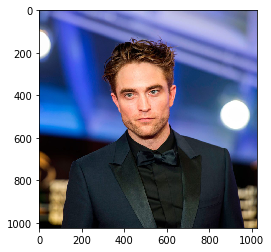

In [263]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [264]:
prompts = ['shirt']

In [265]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


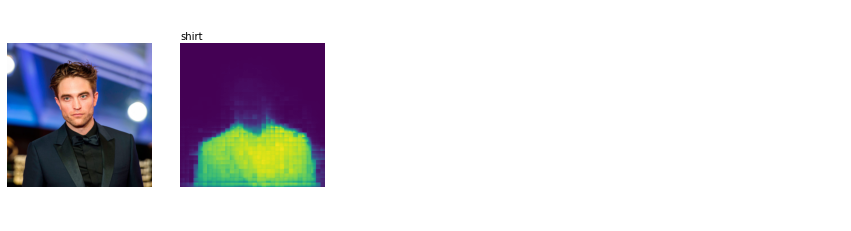

In [266]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [267]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [268]:
img2 = cv2.imread(filename)

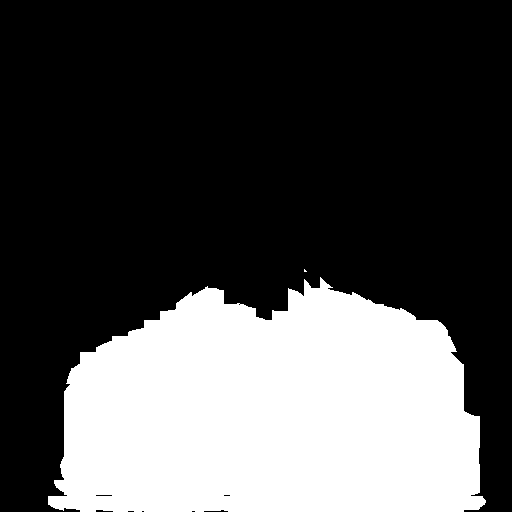

In [269]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [270]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

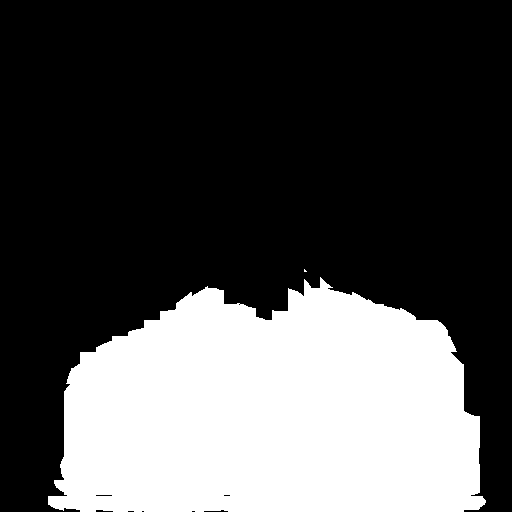

In [271]:
mask

In [278]:
with autocast("cuda"):
    images = pipe(prompt="a yellow flowered holiday shirt", init_image=init_image, mask_image=mask, strength=0.8)["sample"]


0it [00:00, ?it/s]

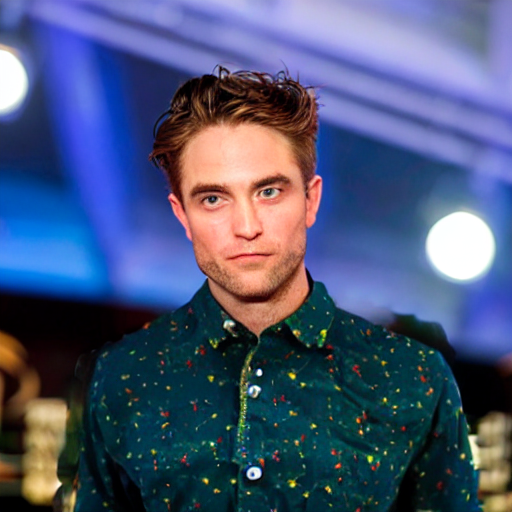

In [279]:
images[0]